## Introduction

Here we present an example for classification. The $status$ variable in the $HR$ dataset is a factor that takes three values $fired$/$ok$/$promoted$. We will create a model for this variable and then we present explainers for this model.

In [1]:
library("DALEX")
head(HR)

Welcome to DALEX (version: 0.2.4).


gender,age,hours,evaluation,salary,status
male,32.58267,41.88626,3,1,fired
female,41.21104,36.34339,2,5,fired
male,37.70516,36.81718,3,0,fired
female,30.06051,38.96032,3,2,fired
male,21.10283,62.15464,5,3,promoted
male,40.11812,69.53973,2,0,fired


Here we create a random forest model for this dataset.

In [2]:
library("randomForest")
library("ceterisParibus")
set.seed(59)

model <- randomForest(status ~ gender + age + hours + evaluation + salary, data = HR)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin

Loading required package: gower


By default the predict.randomForest() function returns classes not scores. This is why we use user-specific predict() function. Here we use two explainers, one will explainer the fired class while the second will take care about the promoted class.

In [3]:
pred1 <- function(m, x)   predict(m, x, type = "prob")[,1]
pred2 <- function(m, x)   predict(m, x, type = "prob")[,2]
pred3 <- function(m, x)   predict(m, x, type = "prob")[,3]

explainer_rf_fired <- explain(model, data = HR[,1:5], 
                              y = HR$status == "fired", 
                              predict_function = pred1, label = "fired")
explainer_rf_ok <- explain(model, data = HR[,1:5], 
                              y = HR$status == "ok", 
                              predict_function = pred2, label = "ok")
explainer_rf_promoted <- explain(model, data = HR[,1:5], 
                               y = HR$status == "promoted", 
                               predict_function = pred3, label = "promoted")

## Multiclass

Ceteris Paribus package can plot many explainers in a single panel. This will be useful for multiclass classification. You can simply create an explainer for each class and plot all these explainers together.

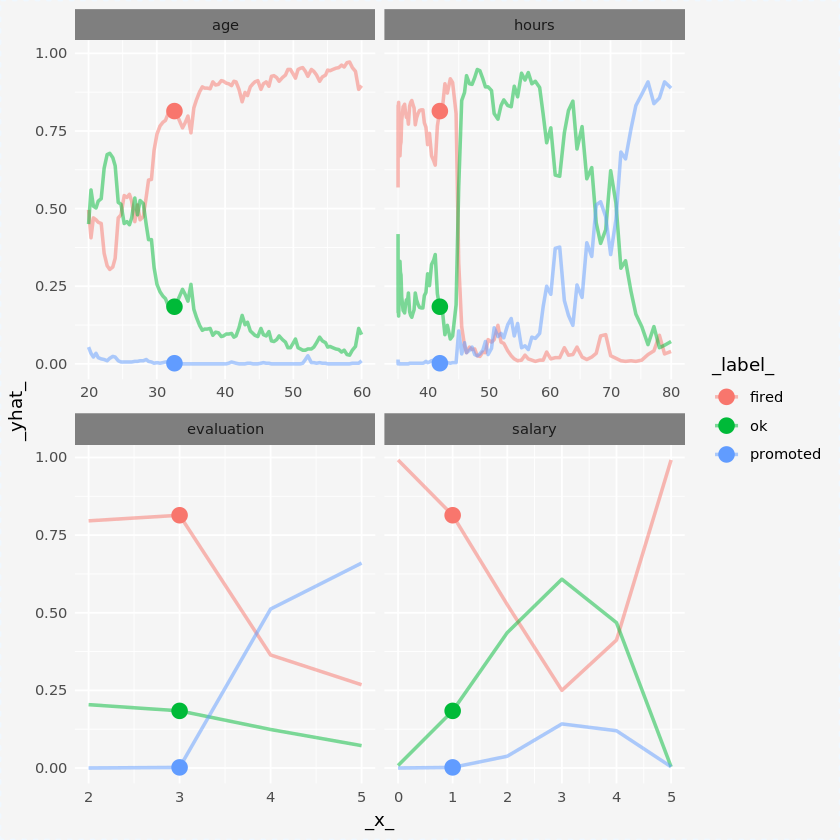

In [4]:
cp_rf1 <- ceteris_paribus(explainer_rf_fired, HR[1,])
cp_rf2 <- ceteris_paribus(explainer_rf_ok, HR[1,])
cp_rf3 <- ceteris_paribus(explainer_rf_promoted, HR[1,])

plot(cp_rf1, cp_rf2, cp_rf3, 
     alpha = 0.5, color="_label_", size_points = 4)

## Individual curves

The explainer_rf_fired explainer is focused on class fired. Let’s see Ceteris Paribus profiles for first 10 individuals.

They are colored with the gender variable. It’s useful since in the model there is an interaction between age and gender. Can you spot it?

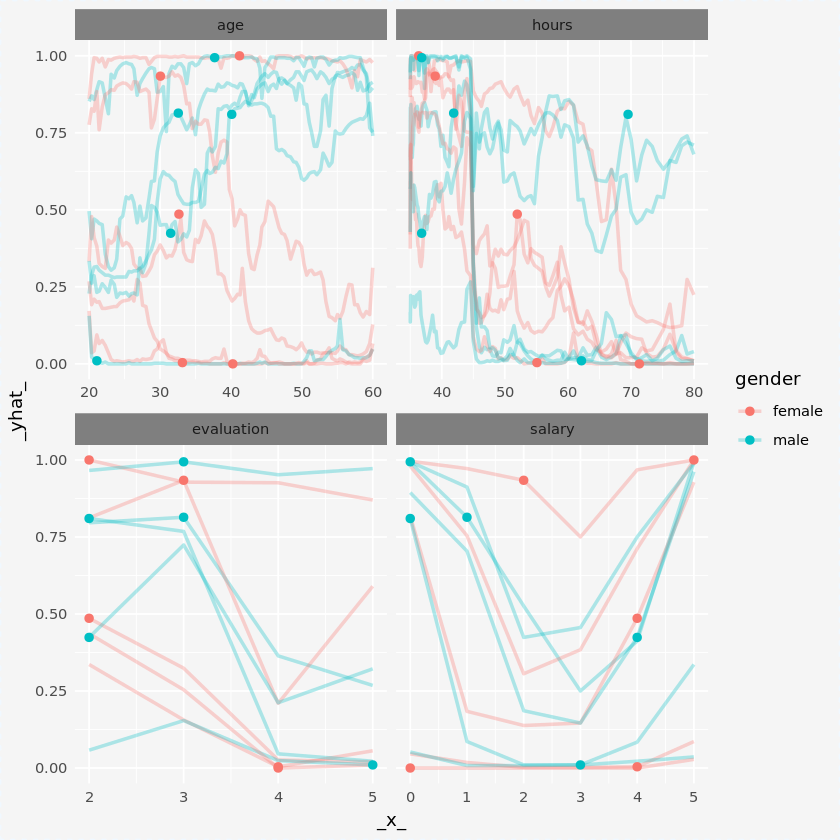

In [5]:
cp_rf_fired <- ceteris_paribus(explainer_rf_fired, HR[1:10,])

plot(cp_rf_fired, color = "gender")

## Partial Dependency Plots

We can plot explainers for two classes (fired and promoted) in the same plot. Here is an example how to do this.

The hours variable is an interesting one. People with low average working hours are on average more likely to be fired not promoted. Also the salary seems to be related with probability of being fired but not promoted.

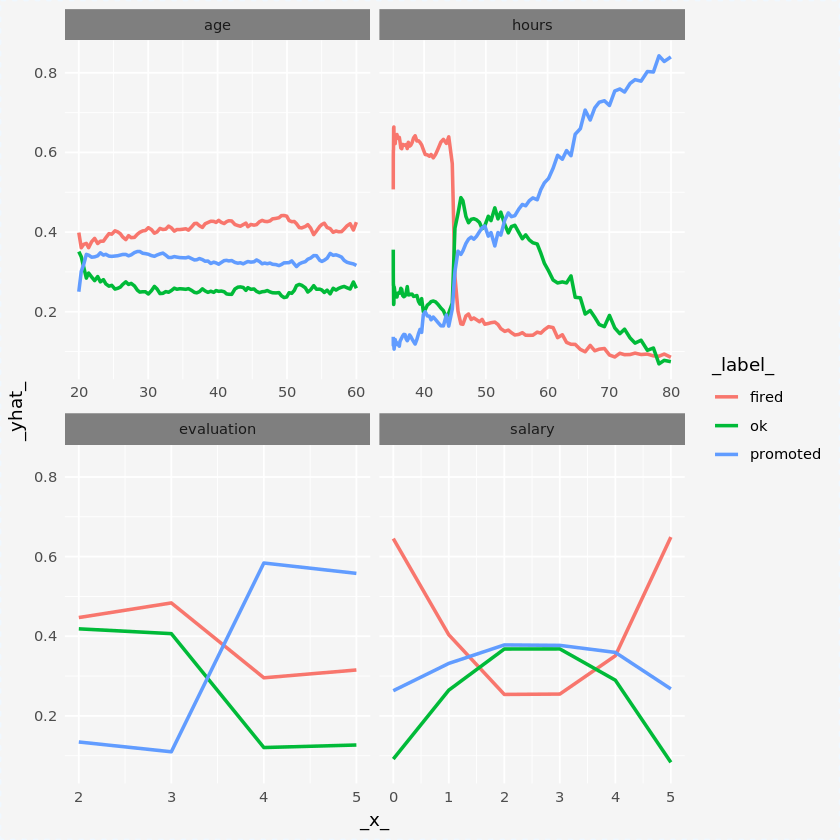

In [6]:
cp_rf1 <- ceteris_paribus(explainer_rf_fired, HR[1:100,])
cp_rf2 <- ceteris_paribus(explainer_rf_ok, HR[1:100,])
cp_rf3 <- ceteris_paribus(explainer_rf_promoted, HR[1:100,])

plot(cp_rf1, cp_rf2, cp_rf3, 
     aggregate_profiles = mean, 
     alpha = 1, show_observations = FALSE, color="_label_")

## Partial Dependency Plots for groups of obervations

Here we will compare the explainer (probability of being fired) across two genders. We know that there is an interaction between gender and age variables. It will be easy to read this interaction from the plot.

In the plot below we will see that both genders behave in all panels except age. For the age variable it looks like younger woman are more likely to be fired while for males the older age is a risk factor.

Is it because employers are afraid of maternity leaves? Maybe, but please note, that this dataset is an artificial/simulated one.

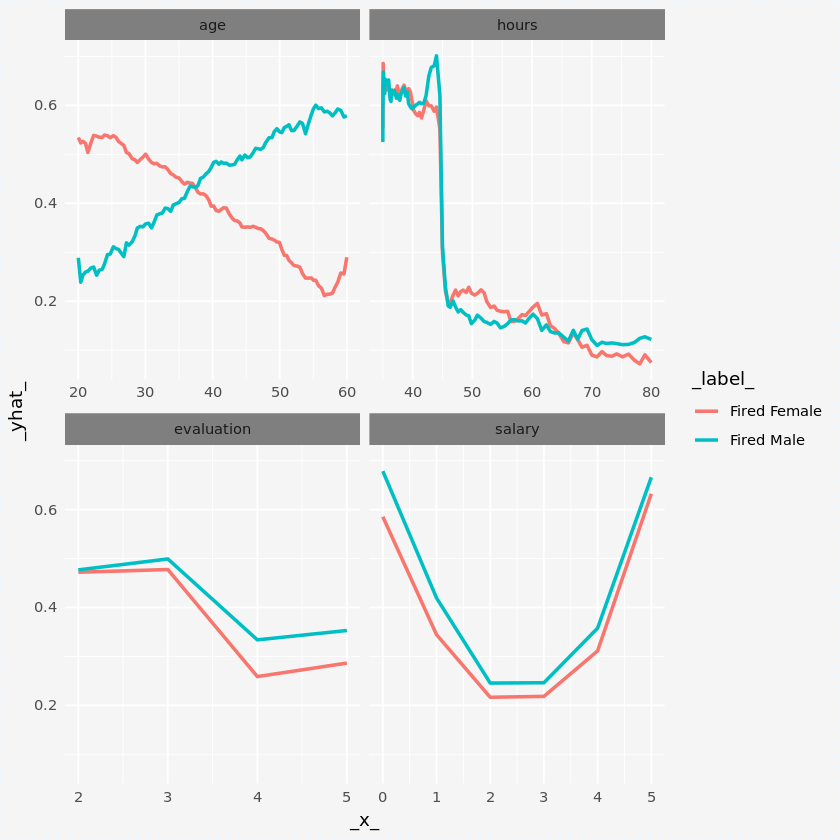

In [7]:
cp_rfF <- ceteris_paribus(explainer_rf_fired, 
                          HR[which(HR$gender == "female")[1:100],])
cp_rfF$`_label_` = "Fired Female"
cp_rfM <- ceteris_paribus(explainer_rf_fired, 
                          HR[which(HR$gender == "male")[1:100],])
cp_rfM$`_label_` = "Fired Male"

plot(cp_rfM, cp_rfF, 
     aggregate_profiles = mean, 
     alpha = 1, show_observations = FALSE, color="_label_")

## More models

Here we have examples for three classification models: random forest, support vector machines, generalized linear model. We focus only on the ‘fired’ class.

Let’s start with examples for a single observation. We need to train models first. Note that predictions are calculated in a different way for different functions, thus we need to prepare moedl specific predict functions.

Here is for the random forest.

In [8]:
library("ceterisParibus")
library("e1071")

model_rf <- randomForest(status ~ gender + age + hours + evaluation + salary, data = HR)
pred_rf_fired <- function(m, x)   predict(m, x, type = "prob")[,1]

explainer_rf_fired <- explain(model, data = HR[,1:5], 
                              y = HR$status == "fired", 
                              predict_function = pred_rf_fired)

Here is for generalized linear model.

In [9]:
model_fired <- glm(status == "fired" ~ gender + age + hours + evaluation + salary, data = HR, family = "binomial")

pred_glm_fired <- function(m, x)   predict.glm(m, x, type = "response")

explainer_glm_fired <- explain(model_fired, data = HR[,1:5], 
                              y = HR$status == "fired", 
                              predict_function = pred_glm_fired)

And here is one for support vector machines.

In [10]:
model_svm_fired <- svm(status ~ gender + age + hours + evaluation + salary, data = HR, probability = TRUE)

pred_svm_fired <- function(m, x) attr(predict(m, x, probability = TRUE), "probabilities")[,1]

explainer_svm_fired <- explain(model_svm_fired, data = HR[,1:5], 
                              y = HR$status == "fired", 
                              predict_function = pred_svm_fired)

Having explainers, we can now create Ceteris Paribus profiles for a selected single observation.

In [11]:
new_obs <- HR[1,]

cp_rf <- ceteris_paribus(explainer_rf_fired, new_obs)
cp_glm <- ceteris_paribus(explainer_glm_fired, new_obs)
cp_svm <- ceteris_paribus(explainer_svm_fired, new_obs)

And we can plot profiles for this observations. Note that both SVM and RF captured the interaction between gender and age. Also they captured the nonlinear relation for salary.

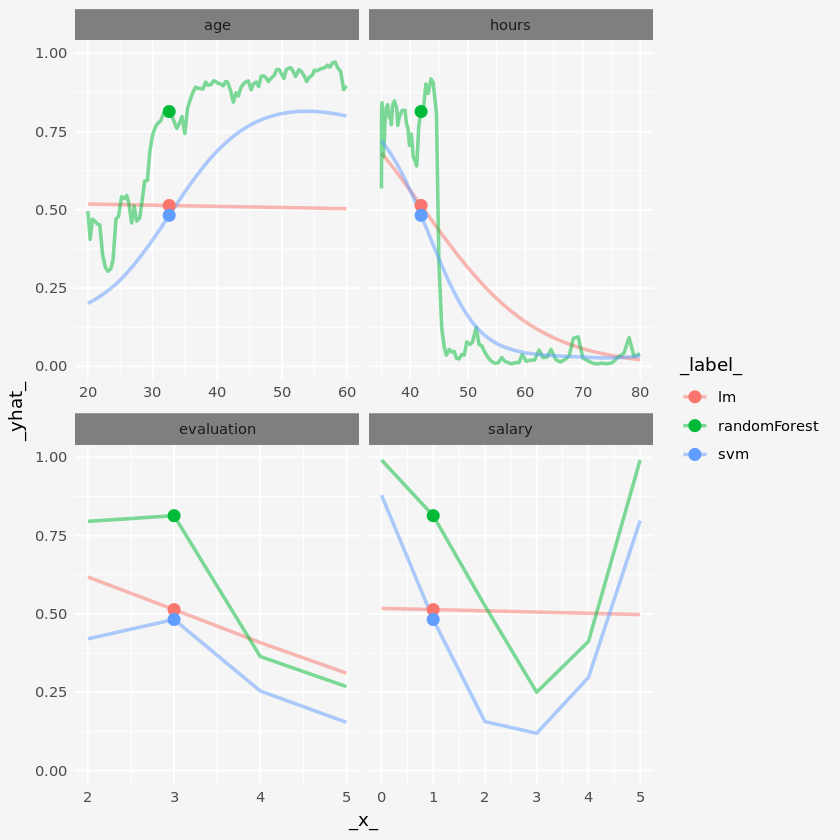

In [12]:
plot(cp_rf, cp_glm, cp_svm,
     alpha = 0.5, size_points = 3, color="_label_")

Now we can calculate average profile for global explanations. Here the average will be calculated based on 100 observations. Note that since age and gender are in interaction, on average there is no relation between score and the age.

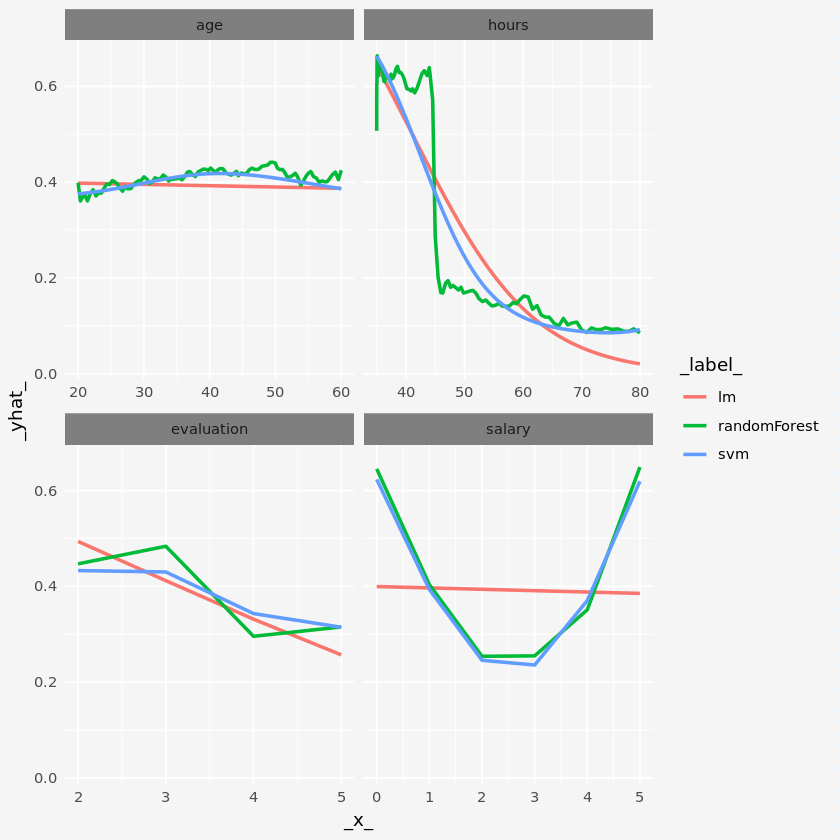

In [13]:
cp_rf <- ceteris_paribus(explainer_rf_fired, HR[1:100,])
cp_glm <- ceteris_paribus(explainer_glm_fired, HR[1:100,])
cp_svm <- ceteris_paribus(explainer_svm_fired, HR[1:100,])

plot(cp_rf, cp_glm, cp_svm,
     aggregate_profiles = mean, 
     alpha = 1, show_observations = FALSE, color="_label_")

## Cheatsheet

Images and codes used in the cheatsheet

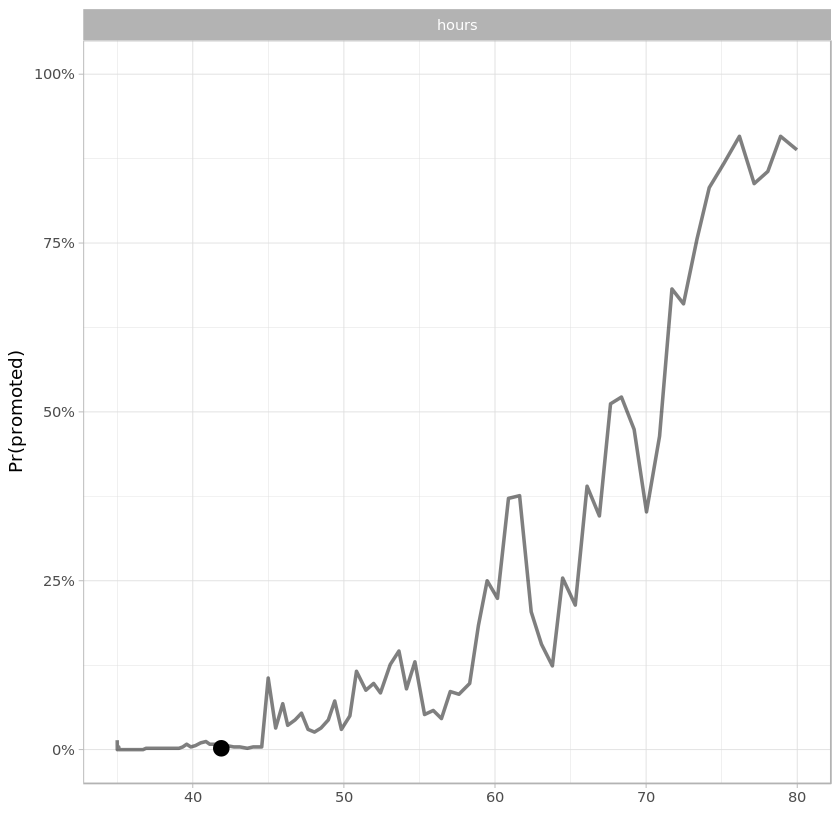

In [14]:
percent <- function (x) 
    paste0(format(round(x, 2) * 100, big.mark = ",", scientific = FALSE, trim = TRUE), "%")

data_1 <- HR[1,]
cp_rf3 <- ceteris_paribus(explainer_rf_promoted, data_1)

plot(cp_rf3, 
     alpha = 0.5, size_points = 4, selected_variables = "hours", 
     as.gg = TRUE) + xlab("") +  scale_y_continuous(limits=c(0,1), name = "Pr(promoted)", labels =percent) + theme_light()

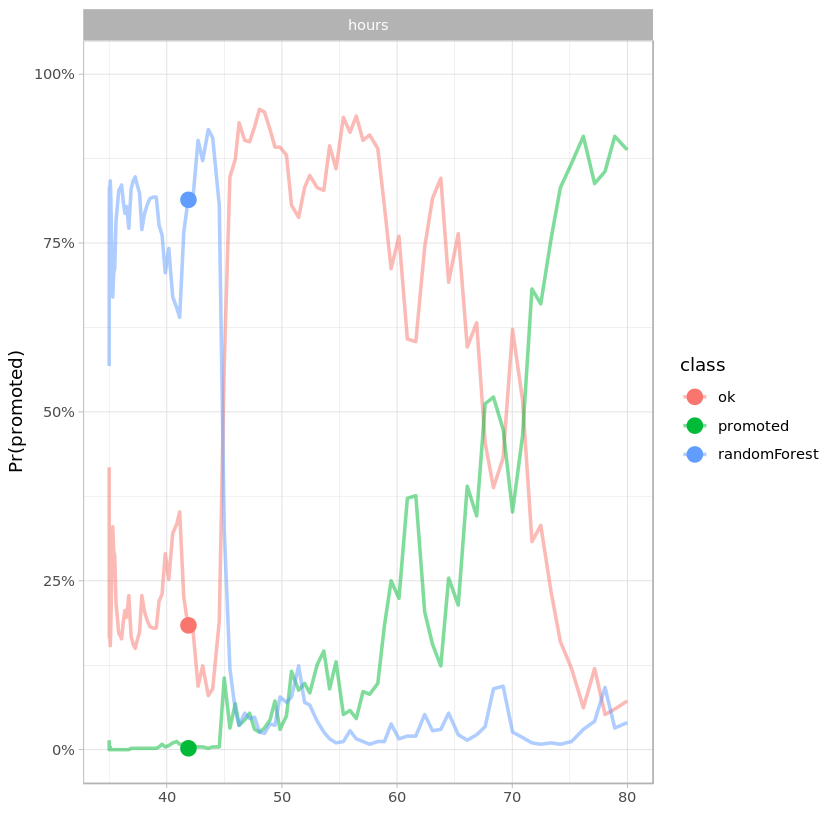

In [15]:
cp_rf1 <- ceteris_paribus(explainer_rf_fired, HR[1,])
cp_rf2 <- ceteris_paribus(explainer_rf_ok, HR[1,])
cp_rf3 <- ceteris_paribus(explainer_rf_promoted, HR[1,])

plot(cp_rf1, cp_rf2, cp_rf3, 
     alpha = 0.5, color="_label_", size_points = 4, selected_variables = "hours", 
     as.gg = TRUE) + xlab("") +  scale_y_continuous(limits=c(0,1), name = "Pr(promoted)", labels = percent) + theme_light() + scale_color_discrete(name = "class")

## Session info

In [16]:
sessionInfo()

R version 3.4.4 (2018-03-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] e1071_1.7-0          ceterisParibus_0.3.0 gower_0.1.2         
[4] ggplot2_3.0.0        randomForest_4.6-14  DALEX_0.2.4         

loaded via a namespace (and not attached):
 [1] jsonlite_1.5       splines_3.4.4      gtools_3.8.1       shiny_1.1.0       
 [5] assert